### SNN WP

In [1]:
!pip install snntorch
import snntorch as snn
import snntorch.functional as SF

from snntorch import spikeplot as splt

from snntorch import spikegen

import torch

import torch.nn as nn

import weight_perturbation as wp

import wandb

In [243]:
run = 15 # Each run, increment this counter by 1
torch.manual_seed(42)

In [244]:
sigma_vals = [1, 1e-1, 1e-2, 1e-3, 1e-4]
lr_vals = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

sigma = sigma_vals[run // len(lr_vals)]
lr = lr_vals[run % len(lr_vals)]
method = "ffd"
epochs = 5
print(sigma, lr)

0.001 0.1


In [245]:
wandb.login()

True

In [246]:
# define a network


class SNN_WP(nn.Module):
    """
    SNN for weight perturbation. Consists of two fully connected layers of LIFs.
    """
    def __init__(self, beta, num_inputs, num_hidden, num_outputs, loss):
        """
        Initialize the network

        Parameters
        ----------
        beta : float
            The memory leakage of the LIF
        num_inputs : int
            The size of the input layer
        num_hidden : int
            The size of the output layer
        num_outputs : int
            The size of the output
        loss : Loss
            The loss used during training
        """
        super(SNN_WP, self).__init__()

        spike_grad = snn.surrogate.fast_sigmoid(slope=25) #needed for BP
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.loss = loss

    def clean_forward(self, x):
        """Wrapper function of forward for readability purposes"""
        return self.forward(x)

    def noisy_forward(self, x, noise):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        noise : dict
            Noise for each network parameter

        Returns
        -------
        spk : Array
            Output spike train
        """
        original_state = self.state_dict()

        params = self.named_parameters()
        trainable_params = {name: p.data for name, p in params if p.requires_grad}
        perturbed_params = wp.dictionary_add(trainable_params, noise)
        self.load_state_dict(perturbed_params, strict=False)
        spk = self.forward(x)

        # reset the parameters back to the unperturbed parameters
        self.load_state_dict(original_state)

        return spk

    def forward(self, x):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains

        Returns
        -------
        spk : Array
            Output spike train
        """
        # self.mem1 = self.lif1.init_leaky()
        # self.mem2 = self.lif2.init_leaky()
        # for step in range(x.shape[0]):
        #     cur1 = self.fc1(x[step])  # post-synaptic current <-- spk_in x weight
        #     spk1, self.mem1 = self.lif1(cur1, self.mem1)  # mem[t+1] <--post-syn current + decayed membrane
        #     cur2 = self.fc2(spk1)
        #     spk2, self.mem2 = self.lif2(cur2, self.mem2)
        # return spk2
        self.mem1 = self.lif1.init_leaky()
        self.mem2 = self.lif2.init_leaky()
        self.output_spikes = torch.zeros((x.shape[1], x.shape[0], x.shape[2]))
        for step in range(x.shape[1]):
            cur1 = self.fc1(x[:, step])  # post-synaptic current <-- spk_in x weight
            spk1, self.mem1 = self.lif1(cur1, self.mem1)  # mem[t+1] <--post-syn current + decayed membrane
            cur2 = self.fc2(spk1)
            spk2, self.mem2 = self.lif2(cur2, self.mem2)

            self.output_spikes[step, :] = spk2
        return self.output_spikes

    def forward_pass(self, x, y, noise=None):
        """Perturbs the weights and runs a forward pass

        Parameters
        ----------
        x : Array
            Input data as spike trains
        y : Array
            True labels
        noise : dict, optional
            Noise for each network parameter

        Returns
        -------
        loss : long
            The loss of the pass
        """
        if noise is None:
            y_pred = self.clean_forward(x)
            return self.loss(y_pred, y)
        else:
            y_pred = self.noisy_forward(x, noise)
            return self.loss(y_pred, y)



In [247]:
class ClassificationDataset(torch.utils.data.Dataset):
    """Classification dataset."""

    def __init__(self, num_samples, timesteps, dim_in, num_classes, means, covariances):
        """Linear relation between input and output"""
        self.num_samples = num_samples * num_classes
        self.timesteps = timesteps
        self.dim_in = dim_in

        labels=[]
        data = []
        for ind, (mean, cov) in enumerate(zip(means, covariances)):
          z = torch.randn(num_samples, len(mean))  # Standard normal samples
          L = torch.linalg.cholesky(cov)  # Cholesky decomposition of covariance matrix
          cluster_data = z @ L.T + mean  # Transform to desired mean and covariance
          data.append(cluster_data)
          #print(torch.ones(num_samples)*ind)
          labels.append(torch.ones(num_samples, dtype=torch.long)*ind)

        data = torch.cat(data, dim=0)
        labels = torch.cat(labels, dim=0)

        idxs = torch.randperm(self.num_samples)
        data = data[idxs, :]
        labels = labels[idxs]
        data_normalized = (data - data.min()) / (data.max() - data.min() + 1e-6)
        self.features = snn.spikegen.rate(data_normalized, timesteps)
        self.labels = labels


    def __len__(self):
        """Number of samples."""
        return self.num_samples

    def __getitem__(self, idx):
        return self.features[:, idx, :], self.labels[idx]

In [248]:
# Parameters for two clusters
means = [torch.tensor([0.0, 1.0]), torch.tensor([-2.0, -2.0])]  # List of mean vectors
covariances = [
    torch.tensor([[1.0, 0.5], [0.5, 1.0]]),  # Covariance matrix for cluster 1
    torch.tensor([[1.0, -0.6], [-0.6, 1.0]])  # Covariance matrix for cluster 2
]
num_samples_per_cluster = 1000  # Samples per cluster

dataset = ClassificationDataset(num_samples_per_cluster, 80, 8,num_classes=2, means=means, covariances=covariances)

train_set, test_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.9), int(len(dataset)*0.1)])


train_loader = torch.utils.data.DataLoader(
    dataset=train_set, batch_size=20, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set, batch_size=20, drop_last=True
)


In [249]:
def batch_accuracy(test_loader, net):
    with torch.no_grad():
        total = 0
        acc = 0
        net.eval()

        test_loader = iter(test_loader)
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            spk_rec = net(data)

            acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
            total += spk_rec.size(1)

    return acc / total

In [250]:
# layer parameters
num_steps = 20
num_inputs = 2
num_hidden = 20
num_outputs = 2
beta = 0.99


# training parameters
loss_hist_wp = []
test_acc_hist_wp = []
device = "cpu"

config = {
    "learning rate": lr,
    "sigma": sigma,
    "beta": beta,
    "method": method,
    "dim_in": num_inputs,
}


loss = SF.ce_rate_loss()
SNN = SNN_WP(beta, num_inputs, num_hidden, num_outputs, loss)

# Initialize the run with appropriate run name
name = f"classification run with lr:{lr} sigma:{sigma}"
run = wandb.init(project="SNN_WP", entity="martin-kraus", config=config, settings=wandb.Settings(init_timeout=180), name=name)


In [251]:
# Training loop for WP

sampler = torch.distributions.Normal(0, sigma)
# make a sampler

with torch.no_grad():
    for e in range(epochs):
        # get input and targets from task
        loss_epoch = []
        for data, targets in iter(train_loader):

            data = data.to(device)
            targets = targets.to(device)

            params = SNN.named_parameters()
            trainable_params = {name: p.data for name, p in params if p.requires_grad}

            loss = SNN.forward_pass(data, targets)

            wp_grad = wp.compute_snn_gradient(
                SNN.forward_pass, data, targets, trainable_params, sampler, method
            )  # do forward passes and compute gradient
            #print(wp_grad)
            new_weights = wp.update_weights(wp_grad, trainable_params, sigma, lr)
            #print(new_weights)
            SNN.load_state_dict(new_weights, strict=False)  # update the weights. Huzzah

            loss_epoch.append(loss.item())

        loss_hist_wp.append(torch.mean(torch.tensor(loss_epoch)))

        with torch.no_grad():
            # Test set forward pass
            test_acc = batch_accuracy(test_loader, SNN)
            print(f"Epoch {e}, Test Acc: {test_acc * 100:.2f}%\n")
            test_acc_hist_wp.append(test_acc.item())

Epoch 0, Test Acc: 51.00%

Epoch 1, Test Acc: 53.00%

Epoch 2, Test Acc: 49.00%

Epoch 3, Test Acc: 65.00%

Epoch 4, Test Acc: 57.00%



[tensor(0.6941), tensor(0.6536), tensor(0.6317), tensor(0.5722), tensor(0.5784)]


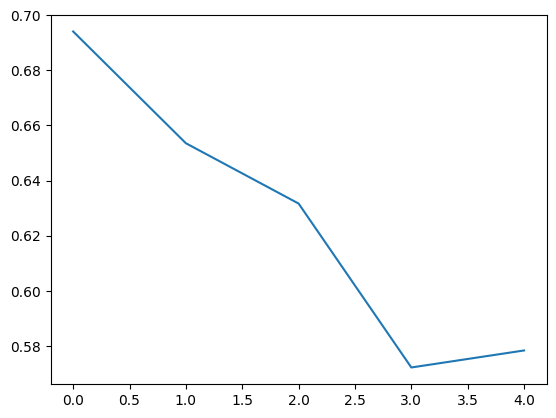

In [252]:
#very vollatile
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_hist_wp)
print(loss_hist_wp)
plt.show()

In [253]:
# layer parameters
num_steps = 20
num_inputs = 2
num_hidden = 20
num_outputs = 2
beta = 0.99
loss = SF.ce_rate_loss()
SNN = SNN_WP(beta, num_inputs, num_hidden, num_outputs, loss)



# training parameters
loss_hist_bp = []
test_acc_hist_bp = []
device = "cpu"

In [254]:
# Training loop for BP

# only run for one particular sigma, since sigma does not influence BP
if sigma == 1:

  optimizer = torch.optim.SGD(params=SNN.parameters(), lr=lr)
  for e in range(epochs):

      loss_epoch = []

      for data, targets in iter(train_loader):
          data = data.to(device)
          targets = targets.to(device)

          SNN.train()

          y_pred = SNN(data)

          # initialize the loss & sum over time
          loss_val = SNN.loss(y_pred, targets)

          # Gradient calculation + weight update
          optimizer.zero_grad()
          loss_val.backward()
          optimizer.step()

          # Store loss history for future plotting
          loss_epoch.append(loss_val.item())

      loss_hist_bp.append(torch.mean(torch.tensor(loss_epoch)))

      with torch.no_grad():
          # Test set forward pass
          test_acc = batch_accuracy(test_loader, SNN)
          print(f"Epoch {e}, Test Acc: {test_acc * 100}%\n")
          test_acc_hist_bp.append(test_acc.item())

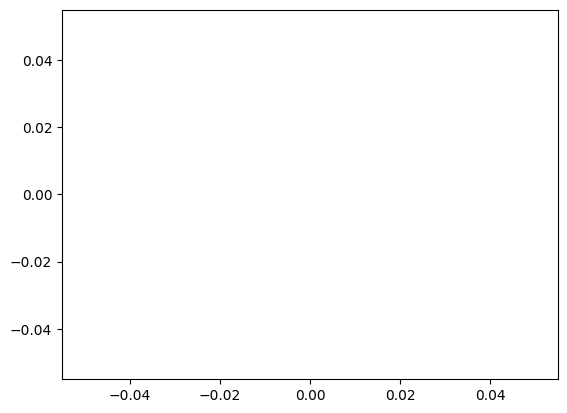

In [255]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_hist_bp)
plt.show()

In [256]:
for e in range(epochs):
  if sigma == 1:
    wandb.log(
        {
            f"classification/train/WP_{method}": loss_hist_wp[e],
            f"classification/test/WP_{method}": test_acc_hist_wp[e],
            "classification/train/BP": loss_hist_bp[e],
            "classification/test/BP": test_acc_hist_wp[e]
        },
        step=e
    )
  else:
    wandb.log(
        {
            f"classification/train/WP_{method}": loss_hist_wp[e],
            f"classification/test/WP_{method}": test_acc_hist_wp[e]
        },
        step=e
    )

In [257]:
wandb.finish()

classification/test/WP_ffd,▂▃▁█▅
classification/train/WP_ffd,█▆▄▁▁
classification/test/WP_ffd,0.57
classification/train/WP_ffd,0.57837


#Data generation


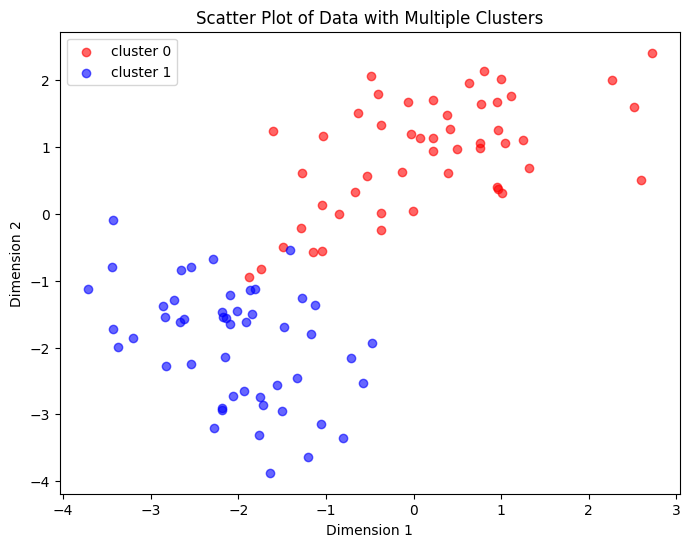

In [258]:
import torch
import matplotlib.pyplot as plt

# Parameters for two clusters
means = [torch.tensor([0.0, 1.0]), torch.tensor([-2.0, -2.0])]  # List of mean vectors
covariances = [
    torch.tensor([[1.0, 0.5], [0.5, 1.0]]),  # Covariance matrix for cluster 1
    torch.tensor([[1.0, -0.6], [-0.6, 1.0]])  # Covariance matrix for cluster 2
]
num_samples_per_cluster = 50  # Samples per cluster

# Generate data for each cluster
labels=[]
data = []
for ind, (mean, cov) in enumerate(zip(means, covariances)):
    z = torch.randn(num_samples_per_cluster, len(mean))  # Standard normal samples
    L = torch.linalg.cholesky(cov)  # Cholesky decomposition of covariance matrix
    cluster_data = z @ L.T + mean  # Transform to desired mean and covariance
    data.append(cluster_data)
    labels.append(torch.ones(num_samples_per_cluster)*ind)

#print(len(data[0]))
# Combine all cluster data
data = torch.cat(data, dim=0)
labels = torch.cat(labels, dim=0)

# print(data)
# print(labels.shape)


# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0][labels==0], data[:, 1][labels==0], c="r",label="cluster 0", alpha=0.6)
plt.scatter(data[:, 0][labels==1], data[:, 1][labels==1], c="b",label="cluster 1", alpha=0.6)
plt.legend()
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Scatter Plot of Data with Multiple Clusters')
plt.show()
